# Questions
* How do we transform text into numbers for processing? 
    * examples where columns are individual words
        * BOW - word counts in a document (row of data)
        * TFIDF - tfidf scores per word in a document (row of data)
    * embeddings
        * word embeddings
            * each word becomes it's own vector 
            * turns documents into matrices
            * context of words
        * sentence embeddings
            * each sentence becomes a vector  
        * character embeddings
            * each character becomes a vector 
    * BERT/ERNIE modeling
        * [Link here](https://medium.com/syncedreview/baidus-ernie-2-0-beats-bert-and-xlnet-on-nlp-benchmarks-51a8c21aa433_)

# Text Classification - Lab

## Introduction

In this lab, we'll use everything we've learned so far to build a model that can classify a text document as one of many possible classes!

## Objectives

You will be able to:

- Perform classification using a text dataset, using sensible preprocessing, tokenization, and feature engineering scheme 
- Use scikit-learn text vectorizers to fit and transform text data into a format to be used in a ML model 



# Getting Started

For this lab, we'll be working with the classic **_Newsgroups Dataset_**, which is available as a training data set in `sklearn.datasets`. This dataset contains many different articles that fall into 1 of 20 possible classes. Our goal will be to build a classifier that can accurately predict the class of an article based on the features we create from the article itself!

Let's get started. Run the cell below to import everything we'll need for this lab. 

# Keyterms 
* stopwords - words that are most common that are noise (the, a, an)

In [14]:
import nltk
from nltk.corpus import stopwords
import string
from nltk import word_tokenize, FreqDist
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score
from sklearn.datasets import fetch_20newsgroups
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
import pandas as pd
import numpy as np
np.random.seed(0)

Now, we need to fetch our dataset. Run the cell below to download all the newsgroups articles and their corresponding labels. If this is the first time working with this dataset, scikit-learn will need to download all of the articles from an external repository -- the cell below may take a little while to run. 

The actual dataset is quite large. To save us from extremely long runtimes, we'll work with only a subset of the classes. Here is a list of all the possible classes:

<img src='classes.png'>

For this lab, we'll only work with the following five:

* `'alt.atheism'`
* `'comp.windows.x'`
* `'rec.sport.hockey'`
* `'sci.crypt'`
* `'talk.politics.guns'`

In the cell below:

* Create a list called `categories` that contains the five newsgroups classes listed above, as strings 
* Get the training set by calling `fetch_20newsgroups()` and passing in the following parameters:
    * `subset='train'`
    * `categories=categories`
    * `remove=('headers', 'footers', 'quotes')` -- this is so that the model can't overfit to metadata included in the articles that sometimes acts as a dead-giveaway as to what class the article belongs to  
* Get the testing set as well by passing in the same parameters, with the exception of `subset='test` 

In [3]:
categories = ['alt.atheism', 'comp.windows.x', 'rec.sport.hockey', 'sci.crypt', 'talk.politics.guns']
newsgroups_train = fetch_20newsgroups(subset='train', categories=categories, remove=('headers', 'footers', 'quotes'))
newsgroups_test = fetch_20newsgroups(subset='test', categories=categories, remove=('headers', 'footers', 'quotes'))

Great! Let's break apart the data and the labels, and then inspect the class names to see what the actual newsgroups are.

In the cell below:

* Grab the data from `newsgroups_train.data` and store it in the appropriate variable  
* Grab the labels from `newsgroups_train.target` and store it in the appropriate variable  
* Grab the label names from `newsgroups_train.target_names` and store it in the appropriate variable  
* Display the `label_names` so that we can see the different classes of articles that we're working with, and confirm that we grabbed the right ones  

In [67]:
df_train = pd.DataFrame()
df_train['article'] = newsgroups_train.data
df_train['label'] = newsgroups_train.target
df_train.head()

,article,label
0,Note: These trial updates are summarized from ...,4
1,,3
2,I'm trying to create a button that has both a ...,1
3,"Hi. I've just finished reading S414, and have ...",4
4,\nUnfortunately your phrasing is ambiguous. R...,0


In [68]:
df_test = pd.DataFrame()
df_test['article'] = newsgroups_test.data
df_test['label'] = newsgroups_test.target
df_test.head()

,article,label
0,[ ... ],4
1,"\nonce upon a time, that's exactly what they w...",4
2,\nWhile I have respect for John's ability and ...,1
3,\nInteresting development. Especially since t...,4
4,"\nI read it when it first came out, and the co...",0


In [4]:
data = newsgroups_train.data
target = newsgroups_train.target
label_names = newsgroups_train.target_names
label_names

['alt.atheism',
 'comp.windows.x',
 'rec.sport.hockey',
 'sci.crypt',
 'talk.politics.guns']

In [11]:
for e, t in zip(data[:5], target):
    print(label_names[t])
    print(e)
    print("-"*100)
    print(" new document")
    print("-"*100)

talk.politics.guns
Note: These trial updates are summarized from reports in the
_Idaho Statesman_ and the local NBC affiliate television
station, KTVB Channel 7.

Randy Weaver/Kevin Harris trial update: Day 4.

Friday, April 16, 1993 was the fourth day of the trial.

Synopsis: Defense attorney Gerry Spence cross-examined agent
Cooper under repeated objections from prosecutor Ronald
Howen.  Spence moved for a mistrial but was denied.

The day was marked by a caustic cross-examination of Deputy
Marshal Larry Cooper by defense attorney Gerry Spence.  Although
Spence has not explicitly stated so, one angle of his stategy
must involve destroying the credibility of agent Cooper.  Cooper is
the government's only eyewitness to the death of agent Degan.
Spence attacked Cooper's credibility by pointing out discrepancies
between Cooper's statements last September and those made in court.
Cooper conceded that, "You have all these things compressed into
a few seconds...It's difficult to remember wh

In [13]:
np.bincount(target)

array([480, 593, 600, 595, 546])

Finally, let's check the shape of `data` to see what our data looks like. We can do this by checking the `.shape` attribute of `newsgroups_train.filenames`.

Do this now in the cell below.

In [12]:
newsgroups_train.filenames.shape

(2814,)

Our dataset contains 2,814 different articles spread across the five classes we chose. 

### Cleaning and Preprocessing Our Data

Now that we have our data, the fun part begins. We'll need to begin by preprocessing and cleaning our text data. As you've seen throughout this section, preprocessing text data is a bit more challenging that working with more traditional data types because there's no clear-cut answer for exactly what sort of preprocessing and cleaning we need to do. Before we can begin cleaning and preprocessing our text data, we need to make some decisions about things such as:

* Do we remove stop words or not?
* Do we stem or lemmatize our text data, or leave the words as is?
* Is basic tokenization enough, or do we need to support special edge cases through the use of regex?
* Do we use the entire vocabulary, or just limit the model to a subset of the most frequently used words? If so, how many?
* Do we engineer other features, such as bigrams, or POS tags, or Mutual Information Scores?
* What sort of vectorization should we use in our model? Boolean Vectorization? Count Vectorization? TF-IDF? More advanced vectorization strategies such as Word2Vec?


These are all questions that we'll need to think about pretty much anytime we begin working with text data. 

Let's get right into it. We'll start by getting a list of all of the english stopwords, and concatenating them with a list of all the punctuation. 

In the cell below:

* Get all the english stopwords from `nltk` 
* Get all of the punctuation from `string.punctuation`, and convert it to a list 
* Add the two lists together. Name the result `stopwords_list` 
* Create another list containing various types of empty strings and ellipses, such as `["''", '""', '...', '``']`. Add this to our `stopwords_list`, so that we won't have tokens that are only empty quotes and such  

# We need to clean our text 
* removing stop words
* removing punctuation
* removing weird characters
* getting our text in a similar case

In [15]:
import string

In [21]:
string.ascii_letters, string.ascii_lowercase, string.ascii_uppercase, string.digits, string.punctuation, string.hexdigits

('abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ',
 'abcdefghijklmnopqrstuvwxyz',
 'ABCDEFGHIJKLMNOPQRSTUVWXYZ',
 '0123456789',
 '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~',
 '0123456789abcdefABCDEF')

In [51]:
stopwords_list = stopwords.words('english')
stopwords_list += ["'s", "'m"]
punctuation_list = list(string.punctuation)
punctuation_list += ["''", '""', '...', '``']
stopwords_list, punctuation_list

(['i',
  'me',
  'my',
  'myself',
  'we',
  'our',
  'ours',
  'ourselves',
  'you',
  "you're",
  "you've",
  "you'll",
  "you'd",
  'your',
  'yours',
  'yourself',
  'yourselves',
  'he',
  'him',
  'his',
  'himself',
  'she',
  "she's",
  'her',
  'hers',
  'herself',
  'it',
  "it's",
  'its',
  'itself',
  'they',
  'them',
  'their',
  'theirs',
  'themselves',
  'what',
  'which',
  'who',
  'whom',
  'this',
  'that',
  "that'll",
  'these',
  'those',
  'am',
  'is',
  'are',
  'was',
  'were',
  'be',
  'been',
  'being',
  'have',
  'has',
  'had',
  'having',
  'do',
  'does',
  'did',
  'doing',
  'a',
  'an',
  'the',
  'and',
  'but',
  'if',
  'or',
  'because',
  'as',
  'until',
  'while',
  'of',
  'at',
  'by',
  'for',
  'with',
  'about',
  'against',
  'between',
  'into',
  'through',
  'during',
  'before',
  'after',
  'above',
  'below',
  'to',
  'from',
  'up',
  'down',
  'in',
  'out',
  'on',
  'off',
  'over',
  'under',
  'again',
  'further',
  'th

Great! We'll leave these alone for now, until we're ready to remove stop words after the tokenization step. 

Next, let's try tokenizing our dataset. In order to save ourselves some time, we'll write a function to clean our dataset, and then use Python's built-in `map()` function to clean every article in the dataset at the same time. 

In the cell below, complete the `process_article()` function. This function should:

* Take in one parameter, `article` 
* Tokenize the article using the appropriate function from `nltk` 
* Lowercase every token, remove any stopwords found in `stopwords_list` from the tokenized article, and return the results 

# The next thing we need to is to separate all our words in a document

In [56]:
def process_article(article,stopwords_list=stopwords_list, punctuation_list=punctuation_list, replace_list=None):
    tokens = nltk.word_tokenize(article) # splitting our doc into individual words 
    if stopwords_list:
        tokens = [token.lower() for token in tokens if token.lower() not in stopwords_list]
    if punctuation_list:
        tokens = [token.lower() for token in tokens if token.lower() not in punctuation_list]
    tokens = [token.strip("_") for token in tokens]
    return tokens    

In [57]:
process_article(doc0, stopwords_list=stopwords_list, punctuation_list=punctuation_list)

['note',
 'trial',
 'updates',
 'summarized',
 'reports',
 'idaho',
 'statesman',
 'local',
 'nbc',
 'affiliate',
 'television',
 'station',
 'ktvb',
 'channel',
 '7',
 'randy',
 'weaver/kevin',
 'harris',
 'trial',
 'update',
 'day',
 '4',
 'friday',
 'april',
 '16',
 '1993',
 'fourth',
 'day',
 'trial',
 'synopsis',
 'defense',
 'attorney',
 'gerry',
 'spence',
 'cross-examined',
 'agent',
 'cooper',
 'repeated',
 'objections',
 'prosecutor',
 'ronald',
 'howen',
 'spence',
 'moved',
 'mistrial',
 'denied',
 'day',
 'marked',
 'caustic',
 'cross-examination',
 'deputy',
 'marshal',
 'larry',
 'cooper',
 'defense',
 'attorney',
 'gerry',
 'spence',
 'although',
 'spence',
 'explicitly',
 'stated',
 'one',
 'angle',
 'stategy',
 'must',
 'involve',
 'destroying',
 'credibility',
 'agent',
 'cooper',
 'cooper',
 'government',
 'eyewitness',
 'death',
 'agent',
 'degan',
 'spence',
 'attacked',
 'cooper',
 'credibility',
 'pointing',
 'discrepancies',
 'cooper',
 'statements',
 'last',
 

Now that we have this function, let's go ahead and preprocess our data, and then move into exploring our dataset. 

In the cell below:

* Use Python's `map()` function and pass in two parameters: the `process_article` function and the `data`. Make sure to wrap the whole map statement in a `list()`.

**_Note:_** Running this cell may take a minute or two!

In [58]:
processed_data = list(map(process_article, data))

Great. Now, let's inspect the first article in `processed_data` to see how it looks. 

Do this now in the cell below.

In [59]:
processed_data[0]

['note',
 'trial',
 'updates',
 'summarized',
 'reports',
 'idaho',
 'statesman',
 'local',
 'nbc',
 'affiliate',
 'television',
 'station',
 'ktvb',
 'channel',
 '7',
 'randy',
 'weaver/kevin',
 'harris',
 'trial',
 'update',
 'day',
 '4',
 'friday',
 'april',
 '16',
 '1993',
 'fourth',
 'day',
 'trial',
 'synopsis',
 'defense',
 'attorney',
 'gerry',
 'spence',
 'cross-examined',
 'agent',
 'cooper',
 'repeated',
 'objections',
 'prosecutor',
 'ronald',
 'howen',
 'spence',
 'moved',
 'mistrial',
 'denied',
 'day',
 'marked',
 'caustic',
 'cross-examination',
 'deputy',
 'marshal',
 'larry',
 'cooper',
 'defense',
 'attorney',
 'gerry',
 'spence',
 'although',
 'spence',
 'explicitly',
 'stated',
 'one',
 'angle',
 'stategy',
 'must',
 'involve',
 'destroying',
 'credibility',
 'agent',
 'cooper',
 'cooper',
 'government',
 'eyewitness',
 'death',
 'agent',
 'degan',
 'spence',
 'attacked',
 'cooper',
 'credibility',
 'pointing',
 'discrepancies',
 'cooper',
 'statements',
 'last',
 

Now, let's move onto exploring the dataset a bit more. Let's start by getting the total vocabulary size of the training dataset. We can do this by creating a `set` object and then using it's `.update()` method to iteratively add each article. Since it's a set, it will only contain unique words, with no duplicates. 

In the cell below:

* Create a `set()` object called `total_vocab` 
* Iterate through each tokenized article in `processed_data` and add it to the set using the set's `.update()` method 
* Once all articles have been added, get the total number of unique words in our training set by taking the length of the set 

In [62]:
total_vocab = set()
for doc in processed_data:
    total_vocab.update(doc)
len(total_vocab)

46735

### Exploring Data With Frequency Distributions

Great -- our processed dataset contains 46,990 unique words! 

Next, let's create a frequency distribution to see which words are used the most! 

In order to do this, we'll need to concatenate every article into a single list, and then pass this list to `FreqDist()`. 

In the cell below:

* Create an empty list called `articles_concat` 
* Iterate through `processed_data` and add every article it contains to `articles_concat` 
* Pass `articles_concat` as input to `FreqDist()`  
* Display the top 200 most used words  

In [64]:
articles_concat = []
for article in processed_data:
    articles_concat += article

In [65]:
articles_freqdist = FreqDist(articles_concat)
articles_freqdist.most_common(200)

[('--', 29501),
 ('x', 4845),
 ("n't", 2933),
 ('1', 2531),
 ('would', 1986),
 ('0', 1975),
 ('one', 1760),
 ('2', 1664),
 ('people', 1243),
 ('use', 1148),
 ('get', 1068),
 ('like', 1037),
 ('file', 1024),
 ('3', 1005),
 ('also', 875),
 ('key', 869),
 ('4', 866),
 ('could', 853),
 ('know', 817),
 ('think', 814),
 ('time', 781),
 ('may', 732),
 ('even', 711),
 ('new', 706),
 ('first', 678),
 ('5', 676),
 ('*/', 674),
 ('system', 673),
 ('well', 671),
 ('information', 646),
 ('make', 644),
 ('right', 639),
 ('see', 636),
 ('many', 635),
 ('two', 633),
 ('/*', 611),
 ('good', 608),
 ('used', 600),
 ('7', 594),
 ('government', 589),
 ('way', 572),
 ('available', 568),
 ('window', 568),
 ('db', 553),
 ('much', 540),
 ('encryption', 537),
 ('6', 537),
 ('using', 527),
 ('say', 523),
 ('gun', 520),
 ('number', 519),
 ('program', 515),
 ('us', 511),
 ('team', 498),
 ('must', 484),
 ('law', 478),
 ('since', 449),
 ('need', 444),
 ('game', 439),
 ('chip', 437),
 ('something', 435),
 ('8', 427),

At first glance, none of these words seem very informative -- for most of the words represented here, it would be tough to guess if a given word is used equally among all five classes, or is disproportionately represented among a single class. This makes sense, because this frequency distribution represents all the classes combined. This tells us that these words are probably the least important, as they are most likely words that are used across multiple classes, thereby providing our model with little actual signal as to what class they belong to. This tells us that we probably want to focus on words that appear heavily in articles from a given class, but rarely appear in articles from other classes. You may recall from previous lessons that this is exactly where **_TF-IDF Vectorization_** really shines!

### Vectorizing with TF-IDF

Although NLTK does provide functionality for vectorizing text documents with TF-IDF, we'll make use of scikit-learn's TF-IDF vectorizer, because we already have experience with it, and because it's a bit easier to use, especially when the models we'll be feeding the vectorized data into are from scikit-learn, meaning that we don't have to worry about doing any extra processing to ensure they play nicely together. 

Recall that in order to use scikit-learn's `TfidfVectorizer()`, we need to pass in the data as raw text documents -- the `TfidfVectorizer()` handles the count vectorization process on it's own, and then fits and transforms the data into TF-IDF format. 

This means that we need to:

* Import `TfidfVectorizer` from `sklearn.feature_extraction.text` and instantiate `TfidfVectorizer()` 
* Call the vectorizer object's `.fit_transform()` method and pass in our `data` as input. Store the results in `tf_idf_data_train` 
* Also create a vectorized version of our testing data, which can be found in `newsgroups_test.data`. Store the results in `tf_idf_data_test`. 


**_NOTE:_** When transforming the test data, use the `.transform()` method, not the `.fit_transform()` method, as the vectorizer has already been fit to the training data. 

In [69]:
df_train.head()

,article,label
0,Note: These trial updates are summarized from ...,4
1,,3
2,I'm trying to create a button that has both a ...,1
3,"Hi. I've just finished reading S414, and have ...",4
4,\nUnfortunately your phrasing is ambiguous. R...,0


In [70]:
df_train['cleaned_article'] = df_train.article.apply(process_article)
df_train.head()

,article,label,cleaned_article
0,Note: These trial updates are summarized from ...,4,"[note, trial, updates, summarized, reports, id..."
1,,3,[]
2,I'm trying to create a button that has both a ...,1,"[trying, create, button, label, bitmap, using,..."
3,"Hi. I've just finished reading S414, and have ...",4,"[hi, 've, finished, reading, s414, several, qu..."
4,\nUnfortunately your phrasing is ambiguous. R...,0,"[unfortunately, phrasing, ambiguous, re-writin..."


In [76]:
df_train['cleaned_article_string'] = df_train.cleaned_article.apply(lambda x: " ".join(x))
df_train.head()

,article,label,cleaned_article,cleaned_article_string
0,Note: These trial updates are summarized from ...,4,"[note, trial, updates, summarized, reports, id...",note trial updates summarized reports idaho st...
1,,3,[],
2,I'm trying to create a button that has both a ...,1,"[trying, create, button, label, bitmap, using,...",trying create button label bitmap using menubu...
3,"Hi. I've just finished reading S414, and have ...",4,"[hi, 've, finished, reading, s414, several, qu...",hi 've finished reading s414 several questions...
4,\nUnfortunately your phrasing is ambiguous. R...,0,"[unfortunately, phrasing, ambiguous, re-writin...",unfortunately phrasing ambiguous re-writing ca...


# BOW model

In [71]:
count_vec = CountVectorizer()

In [77]:
word_count_vecs = count_vec.fit_transform(df_train['cleaned_article_string'], y=df_train['label'])

In [80]:
word_count_vecs.todense().shape

(2814, 36291)

In [96]:
word_count_vecs.todense()[5, 23006]

2

In [91]:
count_vec.vocabulary_

{'note': 23000,
 'trial': 32260,
 'updates': 33168,
 'summarized': 30748,
 'reports': 27209,
 'idaho': 16935,
 'statesman': 30185,
 'local': 20044,
 'nbc': 22503,
 'affiliate': 4745,
 'television': 31420,
 'station': 30192,
 'ktvb': 19222,
 'channel': 8337,
 'randy': 26495,
 'weaver': 34257,
 'kevin': 18881,
 'harris': 16004,
 'update': 33166,
 'day': 10596,
 'friday': 14636,
 'april': 5541,
 '16': 1347,
 '1993': 1558,
 'fourth': 14518,
 'synopsis': 31091,
 'defense': 10839,
 'attorney': 5959,
 'gerry': 15121,
 'spence': 29914,
 'cross': 10100,
 'examined': 13289,
 'agent': 4799,
 'cooper': 9729,
 'repeated': 27172,
 'objections': 23258,
 'prosecutor': 25828,
 'ronald': 27791,
 'howen': 16604,
 'moved': 22009,
 'mistrial': 21631,
 'denied': 10997,
 'marked': 20804,
 'caustic': 8109,
 'examination': 13286,
 'deputy': 11069,
 'marshal': 20843,
 'larry': 19429,
 'although': 5080,
 'explicitly': 13469,
 'stated': 30178,
 'one': 23529,
 'angle': 5264,
 'stategy': 30179,
 'must': 22245,
 'in

In [98]:
first_word = list(count_vec.vocabulary_.keys())[0]
first_word

'note'

23000

In [108]:
def get_word_vec(word):
    index = count_vec.vocabulary_[word]
    return word_count_vecs[:, index].todense().reshape(-1, 1)

In [109]:
get_word_vec(first_word).shape, df_train.shape

((2814, 1), (2814, 4))

In [110]:
df_train[first_word] = get_word_vec(first_word)
df_train.head()

,article,label,cleaned_article,cleaned_article_string,note
0,Note: These trial updates are summarized from ...,4,"[note, trial, updates, summarized, reports, id...",note trial updates summarized reports idaho st...,1
1,,3,[],,0
2,I'm trying to create a button that has both a ...,1,"[trying, create, button, label, bitmap, using,...",trying create button label bitmap using menubu...,0
3,"Hi. I've just finished reading S414, and have ...",4,"[hi, 've, finished, reading, s414, several, qu...",hi 've finished reading s414 several questions...,0
4,\nUnfortunately your phrasing is ambiguous. R...,0,"[unfortunately, phrasing, ambiguous, re-writin...",unfortunately phrasing ambiguous re-writing ca...,0


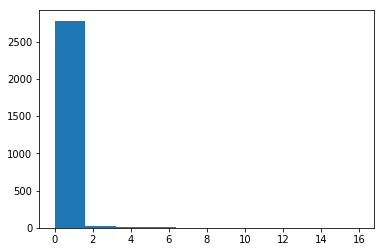

In [113]:
import matplotlib.pyplot as plt
plt.hist(df_train['note'])
plt.show()

In [114]:
mnb = MultinomialNB()

In [116]:
mnb.fit(word_count_vecs, df_train['label'])

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

## Can I predict the test label(s)?

In [117]:
df_test.head(2)

,article,label
0,[ ... ],4
1,"\nonce upon a time, that's exactly what they w...",4


In [118]:
df_test['cleaned_article'] = df_test['article'].apply(process_article)
df_test.head(2)

,article,label,cleaned_article
0,[ ... ],4,[]
1,"\nonce upon a time, that's exactly what they w...",4,"[upon, time, exactly, would, done, everyone, c..."


In [119]:
df_test['cleaned_article_string'] = df_test.cleaned_article.apply(lambda x: ' '.join(x))
df_test.head(2)

,article,label,cleaned_article,cleaned_article_string
0,[ ... ],4,[],
1,"\nonce upon a time, that's exactly what they w...",4,"[upon, time, exactly, would, done, everyone, c...",upon time exactly would done everyone could go...


In [121]:
test_word_vecs = count_vec.transform(df_test['cleaned_article_string'])

### Now that the test data has been conditioned properly I can test the Multi NB model

In [122]:
mnb.score(test_word_vecs, df_test['label'])

0.8654564869193807

### TFIDF (term frequency inverse document frequency)
* some people use it for classification
* I use it for finding stopwords
    * low tfidf scores are stopwords

<img src="images/tfidf.png" />

In [125]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [126]:
vectorizer = TfidfVectorizer()

In [132]:
cleaned_data = list(map(str.lower, data))
cleaned_test = list(map(str.lower, newsgroups_test.data))

In [131]:
tf_idf_data_train = vectorizer.fit_transform(cleaned_data)

In [133]:
tf_idf_data_test = vectorizer.transform(cleaned_test)

In [149]:
tf_idf_data_train.todense()[0, 5517]

0.04139319070174413

In [148]:
vectorizer.vocabulary_['and']

5517

In [150]:
mnb2 = MultinomialNB()

In [151]:
mnb2.fit(tf_idf_data_train, df_train['label'])

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [152]:
mnb2.score(tf_idf_data_test,df_test['label'])

0.8126001067805659

# How can we find stopwords using tfidf? 

In [154]:
df_train.head()

,article,label,cleaned_article,cleaned_article_string,note
0,Note: These trial updates are summarized from ...,4,"[note, trial, updates, summarized, reports, id...",note trial updates summarized reports idaho st...,1
1,,3,[],,0
2,I'm trying to create a button that has both a ...,1,"[trying, create, button, label, bitmap, using,...",trying create button label bitmap using menubu...,0
3,"Hi. I've just finished reading S414, and have ...",4,"[hi, 've, finished, reading, s414, several, qu...",hi 've finished reading s414 several questions...,0
4,\nUnfortunately your phrasing is ambiguous. R...,0,"[unfortunately, phrasing, ambiguous, re-writin...",unfortunately phrasing ambiguous re-writing ca...,0


In [159]:
corpus = [' '.join(df_train['cleaned_article_string'])]

In [160]:
tfidf2 = TfidfVectorizer()

In [163]:
vecs = tfidf2.fit_transform(corpus)

In [178]:
vecs.todense()

matrix([[0.02682013, 0.02399049, 0.00012303, ..., 0.00012303, 0.00012303,
         0.00012303]])

In [171]:
ten_percentile = np.percentile(vecs.todense(), 10)

In [182]:
word_indices = np.where(vecs.todense()<=ten_percentile)[1]

In [183]:
index_vocab = {v:k for k, v in tfidf2.vocabulary_.items()}
index_vocab

{23000: 'note',
 32260: 'trial',
 33168: 'updates',
 30748: 'summarized',
 27209: 'reports',
 16935: 'idaho',
 30185: 'statesman',
 20044: 'local',
 22503: 'nbc',
 4745: 'affiliate',
 31420: 'television',
 30192: 'station',
 19222: 'ktvb',
 8337: 'channel',
 26495: 'randy',
 34257: 'weaver',
 18881: 'kevin',
 16004: 'harris',
 33166: 'update',
 10596: 'day',
 14636: 'friday',
 5541: 'april',
 1347: '16',
 1558: '1993',
 14518: 'fourth',
 31091: 'synopsis',
 10839: 'defense',
 5959: 'attorney',
 15121: 'gerry',
 29914: 'spence',
 10100: 'cross',
 13289: 'examined',
 4799: 'agent',
 9729: 'cooper',
 27172: 'repeated',
 23258: 'objections',
 25828: 'prosecutor',
 27791: 'ronald',
 16604: 'howen',
 22009: 'moved',
 21631: 'mistrial',
 10997: 'denied',
 20804: 'marked',
 8109: 'caustic',
 13286: 'examination',
 11069: 'deputy',
 20843: 'marshal',
 19429: 'larry',
 5080: 'although',
 13469: 'explicitly',
 30178: 'stated',
 23529: 'one',
 5264: 'angle',
 30179: 'stategy',
 22245: 'must',
 179

In [184]:
for index in word_indices:
    print(index_vocab[index])

0000
00000093
000000e5
000005102000
00000510200001
00000ee5
000010af
0001mpc
0005895485
0010
001319
0020
0024
0030
0040000d
0058
0065
0066
0068
0075
008
0088
0096b294
00xkv
010
010256
0115
012
012011
013939
014t4
015
016
01720
01730
018
0188
01880
0195
01h5
02026
021
02142
02174
0223
025258
02903
030
03083
0314
032828
034
035
036
038
0404
0418
042
0435
0440
045
0458
0483
04e
04glvr8a
050524
0511
0530
05qnf
05rov
0600h
062
0639
0646
065
06561
0714
071791
072
073
074
077
07748
07834
0785
0837
0853
0854
0881
08817
08854
08h
092
0936
094
0962
097
099
0_
0_35r
0_e8
0a
0as
0b800h
0b9w
0bjg
0bs
0bsjom
0c_
0c_l
0ct1t
0e
0e0
0eg6g
0er
0ga
0gn
0gx
0h6o481w8h1t2
0hyx
0i1dg
0i91n
0im
0ja
0jd
0jp
0k5
0ki
0ks
0lq
0m6
0mis
0mjx9
0nds8
0niy
0np34
0nt
0nu
0p7
0pn
0pz
0r
0rdf
0rljas
0s7l
0s8
0sw
0sy3
0t0tl_b
0tgm7
0v7fs
0v9g
0vfhtw8s
0vuzc
0vx48
0wa
0wc
0wh
0x10
0x21
0x400000
0x500043
0x70016000
0xa8
0xbe
0xd0000d
0xe0000d
0xf776a96c
0xffffffff
0xj
0xs
0y0
0ycf
0z6m
0zbozv
0zu
1000ff00
1000ff01
1000ff02

badshmseg
badwindow
baggie
bahavior
bahaviour
bail
baillie
baird
bairstow
baiting
baits
bajs4
bakal
bakker
balcony
bales
ballantine
ballentine
ballgame
ballot
ballots
bally
bambi
banana
bandwagon
banesh
banged
bangers
banging
bangladesh
banishment
banjo
bankruptcy
banner
bantam
barbed
baretta
barf
barfly
bargains
barman
barmar
barnabas
barnhart
barns
barons
barre
barrettd
barricades
barriers
baruch
basd
baseless
basetranslation
bash
bashers
bashings
basil
basin
basn
bass
bastardisation
basti
batchelder
bate
batfss
bathroom
battalion
battelle
batter
batting
battled
baudrate
baum
bawa
bayesian
bayonet
bazeries
bb5
bbci
bbh
bboard
bbss
bbx
bby
bc_mbsk1lm4
bcm
bcmp
bcqgz
bcss
bcy2
bd03bj
bdfresize
bdftopcf
bdygwzv
beach_ball
beachball
beachfront
beahvioral
beams
bearable
bearcats
beard
beasties
beaver
beb3
becaue
because
beck
becomming
becouse
bedrich
beechgreen
beef
been
beeps
beet
befor
befriended
befuddlement
beged
beggars
begged
begining
beginner
behaved
behaves
behaving
behing
beholde

depart
dependant
depended
dependency
dependend
depicted
depicts
depletion
deplored
deported
depose
depositing
depositiories
depository
deposits
deprivation
depths
dequate
dequesne
derailed
deranged
derby
dercatch
derision
derisively
derivable
derivate
derivates
derivative
deriving
des3
descendent
descendents
desciption
descriptors
desed
deserted
designates
desirability
deskterm
desolation
desouza
despair
desparate
desparately
desperation
despicable
despised
destoo
destroyers
destroynotify
destruct
destructors
detective
detectives
detector
detering
deteriorated
determinant
determinants
determinism
deterrant
deterring
detonate
detonation
detracts
detriments
detriot
detroits
deuelpm
deuterium
deuteronomy
devaluated
devastation
devellano
developments
develops
deviates
deviations
devide
devilish
devious
devised
devising
devloping
devorski
devote
devoting
devour
devout
dewight
dewy
dexterity
dez
df3
dfs
dga
dgpp5
dgraham
dh7f
dhd6639ztw
dhimmis
dhuse
di4cw
diablery
diagnosed
dial911
dialecti

gudas
guerilla
guesses
guests
gui_classic
gui_info
guideline
guides
guise
gulley
gully
gulped
gum
gummit
guncer
gunfighters
gunman
gunowners
gunshyjudges
gunsmithing
gunsmiths
gunsot
gunther
gurm
gurps
gus
gusarov
gustafson
gusts
gutenberg
gutkowski
gutless
guts
gutted
gutting
guvax
gv
gv_d7
gvc
gvl9
gw9
gwg
gww
gxf6
gxor
gxugiv
gy
gyev
gzj5mm4
gzk1wvy
gzp
h09xiaj0
h1h1
h1j
h1oj627v4b
h1ripr
h24hs
h2e6z1o
h2ph
h2y
h3
h3m6
h3v3
h3x6
h40t9p
h442a
h4hn
h4p
h4w
h5
h58gg9n9nf_spzx3
h5g
h5s
h6
h7
h768
h7yrzhth
h80
h8n
h9a
h_bar
h_e
h_m
h_pi
ha4pawawvjqfys
ha5o5
haaaaaaaaaahahahahahahahahahahaha
haapakoski
habitants
hackey
hade
hadgun
haff
hafner
hagar
hagen
hager
hagerp
hah
hahahaha
hahn
hairy
halbrook
halfs
halftime
halfway
hallam
hallandale
hallelujah
hallmark
halloween
hallucinating
ham
hamakawa
hamalainen
hamblin
hamburger
hamburgers
hameenlinna
hammered
hammond
hamr
hamradio
hamu
hancock
handcoded
handedly
hander
handers
handgrenades
handguncontrolinc
handmaid
handset
hangee
hangfire
ha

lafayette
lafleur
laforest
lagging
lags
laguna
lahti
lak83
laker
lakshmivarahan
lalor
lamar
lambasted
lambasting
lambert
lambros
lament
lamentation
lamenting
lamont
lamps
lan
lancaster
lancorp
landlines
landlords
landover
landshut
lanera
langage
languish
langway
lanl
lanny
laos
lap
lapp
lapsed
lar
lariviere
larryc
laserprinters
lassaiz
lasse
lathe
latin
laud
laudable
lauded
lauderdale
laughs
launched
laundromat
laureate
laurence
lawbook
lawbreaker
lawenforcmentfield
lawers
lawfulness
lawmaking
lawnmower
lawwed
layered
laymans
laypeople
layperson
lazar
lazaro
lazarum
laziness
lbdev7c
lc05ak
ld4c
ldconfig
ldgo
ldn
ldnet
lds
le1
leaflets
leahy
leaned
leaning
leanings
leapard
leaps
leased
leases
leashed
leather
leauge
leavening
lecom
lecommandeur
lees
leffler
leftout
leftovers
leftward
lefty
legalists
legalities
legalization
legalized
legend
leghold
legitimize
legitmate
legzryx
lehey
lehmer
lehrer
lehtinen
leif
leinen
leisher
lelf
lelie
lem79
lemis
lemming
lemmings
lempel
lems
lenaduzzi
le

outbreak
outcast
outclass
outclassed
outcry
outfits
outgunned
outland
outlets
outlines
outlining
outlived
outmatched
outofcontrol
outplayed
outplaying
outrageously
outreach
outset
outshoot
outshooting
outshot
outsider
outsiders
outstrips
outta
outvoting
outweighed
ov76
ovation
oveo
overage
overanalyze
overboard
overcame
overconfidence
overconfident
overdue
overflowing
overgrazed
overhauled
overheard
overhyped
overjoyed
overlaid
overlapped
overlayplane
overloaded
overloading
overmatched
overmuch
overpopulated
overpowered
overreact
overridden
overrideredirect
overrides
overrideshell
overrideshellwidgetclass
overriding
overrule
overrun
overseen
oversights
oversimplify
oversimplifying
overt
overtaken
overthrew
overthrowing
overthrown
overtimes
overturned
overturning
overuse
overviews
overwhelmed
overwrought
owe
owg
own
oxide
oxnard
oxymoronic
oy1
oyb
oz2f34
oz6864
ozland
p0
p0b
p165
p1f
p1hjm
p1s
p1wl9g3p
p2f9
p31
p3h
p42nq
p4f
p4m
p53
p54be
p57rsa
p5j
p6
p67d
p6j
p6wu
p6y7j4jbnlv
p74
p7ip

satisfactorily
satisfactory
satisfies
satisfying
satisified
sator
saturate
saturdays
saturn
sauer
saunders
sausage
savebuff
savelines
saver
saville
saviors
saviour
savvy
sawdust
sax
sayles
sbar_bw
sbar_width
sbcs
sbj2
sbuk
sc6p
scalable
scalars
scales
scaling
scalping
scammed
scams
scandal
scandanavians
scandinavium
scanf
scanlon
scapegoat
scarab
scarce
scarcely
scarf
scarff
scars
scatter
scattered
scenaro
scepter
sceptic
scerban
schabel
scheduler
schedules
scheuer
schietke
schiller
schilling
schirf
schism
schlafly
schmautz
schmetto
schmettow
schoendfeld
schoene
schoenie
scholarships
schoonship
schott
schroede
schwarz
schwarzkopf
schweigler
schwerelos
scientology
scifi
scissor
sck7cd1
sco1
scoenfeld
scol
scolding
scomail
scond
scopaint
scorecard
scorn
scorpion
scot
scoterm
scotsmen
scowen
scrabeling
scrambleing
scramblers
scrap
scrapper
scraps
scratched
scratches
scratchpad
screamed
screams
screenplay
scribe
scrimmage
scriptura
scriptural
scrollback
scrolled
scrolls
scrooges
scslwide
s

swildens
swindow
swine
switchblade
swooped
swords
sworn
swtich
sx45
sx65
sxk
sxm
sxp
sybase
sydors
syllabi
syllable
syllogisms
sylvania
symbmath
symbolic_math
symbolized
symetric
symlink
symlinks
symms
symp
sympathize
symptom
symthe
syn
synch
synchronicity
synchronised
synchronization
syncscrollbars
syndicates
synonymous
synoptic
syr
sysadmins
syslibs
sysrq
systemhouse
sysvr3
sysvr4
sz
szebra
t0
t0kiaj
t0y
t17
t1s
t2b1l
t2n
t2u
t2wd
t34vu1
t3p
t3w
t3zhr2
t4
t5
t5flannib9l
t5j
t5p4i6q7
t6d
t6le
t7
t7f
t7s
t8
t8f
t8qrd9
t8w4o
t9
t9r6
t_accept
t_alloc
t_bind
t_close
t_connect
t_errno
t_error
t_listen
t_look
t_ng4
t_open
t_rcv
t_rcvdis
t_unbind
tablet
tablewidgetclass
tabloids
tabular
tack
tacking
tackling
tacky
tacoma
tagalog
tagged
tailed
tailor
tails
tailspins
taintperl
taiwan
takahashi
taker
taketh
takprvmtd7t
talbert
talbot
talionis
talkies
taller
tallking
tallon
tally
tam
tampered
tamperproof
tangential
tanqueray
taoism
tarasov
tardo
targa
targemasters
tarnold
tarrant
tasking
tasmani

xcdfa6
xcdmfm
xcessory
xcfk7
xchangewindowattributes
xchecktypedwindowevent
xchess
xchron
xcje9mfwt
xclient
xclients
xclipboard
xclosedisplay
xcmsdb
xcmsstorecolors
xcmstekhvcquerymaxv
xcmstekhvcqueryminv
xcmstest
xconndis
xconnectionnumber
xcop
xcp73y
xcreateregion
xcteatewindow
xcursor
xcursor4
xcutsel
xd3pn
xdbg
xdebug
xdefaultgcofscreen
xdefinecursor
xdesigner
xdisplayheight
xdisplaywidth
xdomain
xdpr
xdrawpoint
xdswm
xdtm
xdump1
xdv
xe5nbq
xed8
xedit
xei
xelm
xengine
xenon
xenophobe
xenophobes
xenophobic
xenvironment
xerkyi
xerrors
xess
xexposeevent
xeyes
xfacemaker2
xfaq2texinfo
xfd
xfedor
xfm2
xfontsel
xg
xga2
xgas
xgc
xget_selection
xgetatomname
xgetftp
xgetmodifiermapping
xgetpixel
xgkswidget
xgod
xgrab
xgroups
xgsv
xh
xh3
xh_l
xhi
xhibit
xhp
xhr
xiconfiywindow
xicrp
xid
xie
xifileselector
xiii
ximagehandler
xinputextension
xinternatom
xivz
xj2
xjen
xk
xk9j
xkill
xkxmodhcpf
xlab
xlibint
xlisp
xlogo
xlprj
xlsatoms
xlsclients
xm4
xm9
xmag
xmailtool
xmarc
xmcr_cancel
xmcr_help
xm

### Modeling Our Data

Great! We've now preprocessed and explored our dataset, let's take a second to see what our data looks like in vectorized form. 

In the cell below, get the shape of `tf_idf_data`.

In [20]:
tf_idf_data_train.shape

(2814, 36622)

Our vectorized data contains 2,814 articles, with 36,622 unique words in the vocabulary. However, the vast majority of these columns for any given article will be zero, since every article only contains a small subset of the total vocabulary. Recall that vectors mostly filled with zeros are referred to as **_Sparse Vectors_**. These are extremely common when working with text data. 

Let's check out the average number of non-zero columns in the vectors. Run the cell below to calculate this average. 

In [153]:
non_zero_cols = tf_idf_data_train.nnz / float(tf_idf_data_train.shape[0])
print("Average Number of Non-Zero Elements in Vectorized Articles: {}".format(non_zero_cols))

percent_sparse = 1 - (non_zero_cols / float(tf_idf_data_train.shape[1]))
print('Percentage of columns containing 0: {}'.format(percent_sparse))

Average Number of Non-Zero Elements in Vectorized Articles: 107.28038379530916
Percentage of columns containing 0: 0.9970706028126451


As we can see from the output above, the average vectorized article contains 107 non-zero columns. This means that 99.7% of each vector is actually zeroes! This is one reason why it's best not to create your own vectorizers, and rely on professional packages such as scikit-learn and NLTK instead -- they contain many speed and memory optimizations specifically for dealing with sparse vectors. This way, we aren't wasting a giant chunk of memory on a vectorized dataset that only has valid information in 0.3% of it. 

Now that we've vectorized our dataset, let's create some models and fit them to our vectorized training data. 

In the cell below:

* Instantiate `MultinomialNB()` and `RandomForestClassifier()`. For random forest, set `n_estimators` to `100`. Don't worry about tweaking any of the other parameters  
* Fit each to our vectorized training data 
* Create predictions for our training and test sets
* Calculate the `accuracy_score()` for both the training and test sets (you'll find our training labels stored within the variable `target`, and the test labels stored within `newsgroups_test.target`) 

In [22]:
nb_classifier = MultinomialNB()
rf_classifier = RandomForestClassifier(n_estimators=100)

In [23]:
nb_classifier.fit(tf_idf_data_train, target)
nb_train_preds = nb_classifier.predict(tf_idf_data_train)
nb_test_preds = nb_classifier.predict(tf_idf_data_test)

In [24]:
rf_classifier.fit(tf_idf_data_train, target)
rf_train_preds = rf_classifier.predict(tf_idf_data_train)
rf_test_preds = rf_classifier.predict(tf_idf_data_test)

In [25]:
nb_train_score = accuracy_score(target, nb_train_preds)
nb_test_score = accuracy_score(newsgroups_test.target, nb_test_preds)
rf_train_score = accuracy_score(target, rf_train_preds)
rf_test_score = accuracy_score(newsgroups_test.target, rf_test_preds)

print("Multinomial Naive Bayes")
print("Training Accuracy: {:.4} \t\t Testing Accuracy: {:.4}".format(nb_train_score, nb_test_score))
print("")
print('-'*70)
print("")
print('Random Forest')
print("Training Accuracy: {:.4} \t\t Testing Accuracy: {:.4}".format(rf_train_score, rf_test_score))

Multinomial Naive Bayes
Training Accuracy: 0.9531 		 Testing Accuracy: 0.8126

----------------------------------------------------------------------

Random Forest
Training Accuracy: 0.9851 		 Testing Accuracy: 0.7896


### Interpreting Results

**_Question:_** Interpret the results seen above. How well did the models do? How do they compare to random guessing? How would you describe the quality of the model fit?

Write your answer below:

In [ ]:
"""
The models did well. Since there are five classes, the naive accuracy rate (random guessing) would be 20%. 
With scores of 78 and 81 percent, the models did much better than random guessing. 
There is some evidence of overfitting, as the scores on the training set are much higher than those of the test set. 
This suggests that the models' fits could be improved with some tuning.
"""

# Summary

In this lab, we used our NLP skills to clean, preprocess, explore, and fit models to text data for classification. This wasn't easy -- great job!!